In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
file_path = '../../knowledgebase/evaluated_encoded_samples.jsonl'

In [3]:
with open(file_path, 'r') as file:
    df = pd.read_json(file, lines = True)

df.sample(5)

,id,query,dense_score,sparse_score,hybrid_score,gt_answer,best_answer,label,label_encoded
5983,e14b422a-bce0-42fc-8b08-e14b154037be,I'm interested in history seminars. Does the F...,0.876570,0.873862,0.858875,"Yes, they do. The Oberseminar of the Chair of ...","based on the retrieved documents, there is no ...",dense,0
9775,42e3e204-4da3-4a17-beba-856072895968,What can universities learn from the targeted ...,0.857258,0.864975,0.859986,Universities can learn a lot from the targeted...,universities can learn several strategies from...,sparse,1
7881,58c9d7a4-7aad-47c7-bd9c-7e9bca76861f,What is the significance of the Friedrich-Alex...,0.781538,0.851454,0.779017,FAU plays a significant role in promoting tole...,friedrich-alexander-universität erlangen-nürnb...,sparse,1
8305,4fb8a930-7a49-4cc9-9bfd-a3fe9c8ebead,I'm interested in learning more about the acad...,0.865129,0.853292,0.865324,Certainly! One notable course at FAU is 'Grund...,friedrich-alexander-universität erlangen-nürnb...,hybrid,2
6816,c9441c0c-82b2-4a76-8a80-1bd8ac29ce58,I've heard about the importance of physical ac...,0.875157,0.856173,0.869660,Absolutely! Regular physical activity and trai...,physical activity is indeed very important for...,dense,0


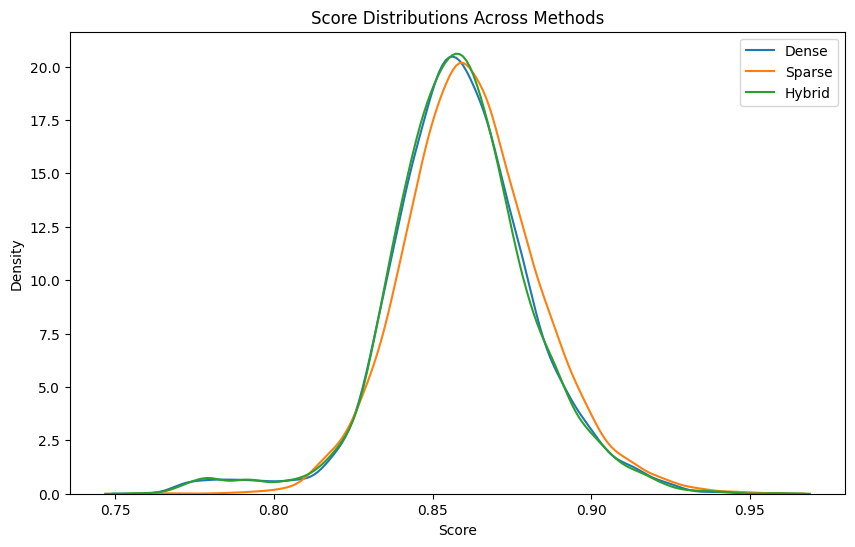

In [4]:
# Plot score distributions for dense/sparse/hybrid
plt.figure(figsize=(10, 6))
sns.kdeplot(df['dense_score'], label='Dense')
sns.kdeplot(df['sparse_score'], label='Sparse')
sns.kdeplot(df['hybrid_score'], label='Hybrid')
plt.title("Score Distributions Across Methods")
plt.xlabel("Score")
plt.legend()
plt.show()

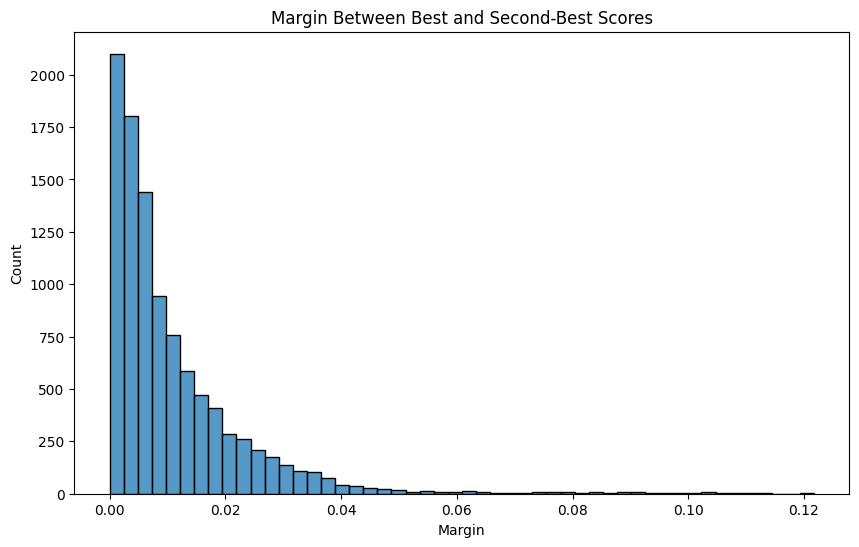

Ambiguous labels (margin < 0.05): 98.4%


In [5]:
def get_score_margin(row):
    scores = [row['dense_score'], row['sparse_score'], row['hybrid_score']]
    scores_sorted = sorted(scores, reverse=True)
    return scores_sorted[0] - scores_sorted[1]

df['score_margin'] = df.apply(get_score_margin, axis=1)

# Plot margin distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['score_margin'], bins=50)
plt.title("Margin Between Best and Second-Best Scores")
plt.xlabel("Margin")
plt.ylabel("Count")
plt.show()

# Quantify ambiguous labels (margin < threshold)
threshold = 0.05  # Adjust based on your score range
ambiguous = df[df['score_margin'] < threshold]
print(f"Ambiguous labels (margin < {threshold}): {len(ambiguous)/len(df):.1%}")

In [6]:
sample_ambiguous = ambiguous.sample(5, random_state=42)[
    ['query', 'dense_score', 'sparse_score', 'hybrid_score', 'label']
]
display(sample_ambiguous)

,query,dense_score,sparse_score,hybrid_score,label
4198,"Hi, I'm a student at FAU and I'm curious about...",0.848066,0.847598,0.837067,dense
4139,What kind of research and academic programs do...,0.870488,0.896730,0.865363,sparse
1769,What kind of research and academic interests d...,0.776014,0.873307,0.841942,sparse
4824,What kind of topics are covered in the Oceanog...,0.873689,0.888145,0.884214,sparse
6495,"Hey, I've heard there are some security issues...",0.773931,0.893556,0.890808,sparse


In [7]:
# Check if labels truly correspond to max scores
def check_label_accuracy(row):
    max_method = np.argmax([row['dense_score'], row['sparse_score'], row['hybrid_score']])
    label_map = {'dense': 0, 'sparse': 1, 'hybrid': 2}
    return (max_method == label_map[row['label']])

df['label_correct'] = df.apply(check_label_accuracy, axis=1)
print(f"Label accuracy: {df['label_correct'].mean():.1%}")

Label accuracy: 100.0%


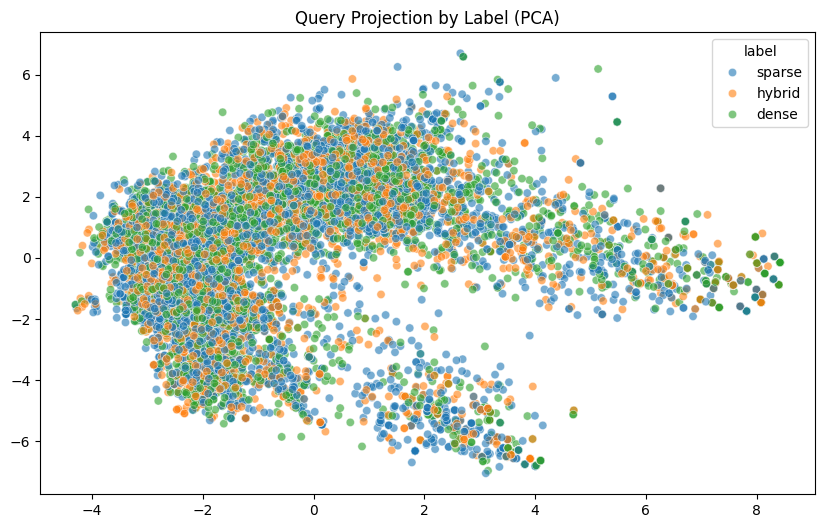

In [8]:
# PCA visualization of queries (colored by label)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF or embeddings
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['query'])

# Reduce dimensionality
X_scaled = StandardScaler().fit_transform(X.toarray())
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['label'], alpha=0.6)
plt.title("Query Projection by Label (PCA)")
plt.show()